In [30]:
import torch, torch.nn as nn, torch.nn.functional as F
from einops import rearrange, repeat
from torch import einsum


In [31]:
class DynamicPositionBias(nn.Module):
    '''taken From Phil Wang's x-transformers library'''
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False, activation=nn.SiLU):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            activation()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                activation()
            ))

        self.mlp.append(nn.Linear(dim, heads))

    @staticmethod
    def fetch_module_kwargs(kwargs):
        return {
            'dim': kwargs.get('dpos_dim', 64),
            'depth': kwargs.get('dpos_depth', 2),
            'log_distance': kwargs.get('dpos_log_distance', False),
            'norm': kwargs.get('dpos_norm', False)
        }


    def forward(self, i, j, device, dtype):
        # get the (i x j) matrix of distances
        assert i >= 1 and j >= 1 and i <= j, 'I should be in the range [1, j] and j >= 1'
        seq_arange = torch.arange(i, device = device)
        context_arange = torch.arange(j, device = device)
        indices = rearrange(seq_arange, 'i -> i 1') - rearrange(context_arange, 'j -> 1 j')
        indices += (j-1)
        
        # input to continuous positions MLP
        pos = torch.arange(-i + 1, (j+i), device = device, dtype = dtype)
        pos = rearrange(pos, '... -> ... 1')
     
        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos) 

        # get position biases        
        bias = pos[indices]
        bias = rearrange(bias, 'i j h -> h i j')
        return bias

In [35]:
class DynamicPositionBias(nn.Module):
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False, activation=nn.SiLU):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            activation()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                activation()
            ))

        self.mlp.append(nn.Linear(dim, heads))

    def forward(self, n, device, dtype):

        # get the (n x n) matrix of distances
        seq_arange = torch.arange(n, device = device)
        context_arange = torch.arange(n, device = device)
        indices = rearrange(seq_arange, 'i -> i 1') - rearrange(context_arange, 'j -> 1 j')
        indices += (n - 1)
        
        # input to continuous positions MLP
        pos = torch.arange(-n + 1, n, device = device, dtype = dtype)
        pos = rearrange(pos, '... -> ... 1')
        return pos[indices]
        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos)

        # get position biases        
        bias = pos[indices]
        bias = rearrange(bias, 'i j h -> h i j')
        return bias

In [43]:
pos = DynamicPositionBias(64, heads = 8, depth = 2, log_distance = False)
pos = pos(50, device = 'cpu', dtype = torch.float32).squeeze(-1)
print(pos[10])
#'pos.squeeze(-1)
#plt.plot(pos[:,10].T.detach().numpy())

tensor([ 10.,   9.,   8.,   7.,   6.,   5.,   4.,   3.,   2.,   1.,   0.,  -1.,
         -2.,  -3.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9., -10., -11., -12., -13.,
        -14., -15., -16., -17., -18., -19., -20., -21., -22., -23., -24., -25.,
        -26., -27., -28., -29., -30., -31., -32., -33., -34., -35., -36., -37.,
        -38., -39.])


In [133]:
class ReLUSquared(nn.Module):
    def forward(self, x):
        return torch.pow(F.relu(x), 2)

def l2norm(t, groups = 1, dim = -1):
    if groups == 1:
        return F.normalize(t, p = 2, dim = dim)
    t = rearrange(t, '... (g d) -> ... g d', g = groups)
    t = F.normalize(t, p = 2, dim = dim)
    return rearrange(t, '... g d -> ... (g d)')


class CosineAttention(nn.Module):
    def __init__(
        self,
        n_feats,
        head_dim,
        n_heads,
        dropout=0.1,
        bias=False,
        temperature=15.5,
        return_attention=False,
        causal=False,
        activation='softmax',
        **kwargs
    ):
        super().__init__()
        assert activation in ['relusq', 'softmax']
        self.shared_kv = kwargs.get('shared_kv', False)
        self.talking_heads = kwargs.get('talking_heads', False)
        self.cache_kv = kwargs.get('cache_kv', False) # whether prev key and values are used 
        

        self.n_feats, self.head_dim, self.n_heads = n_feats, head_dim, n_heads
        self.dropout = nn.Dropout(dropout)
        self.bias = bias
        self.return_attention = return_attention
        self.causal = causal

        if self.talking_heads:
            self._head_proj = nn.Conv2d(n_heads, n_heads, (1, 1))

        self.temperature = torch.nn.Parameter(torch.tensor(temperature), requires_grad=True) if isinstance(temperature, float) else temperature

        self.activation = ReLUSquared() if activation == 'relusq' else nn.Softmax(dim=-1)

        if not self.shared_kv:
            self.qkv_proj = nn.Linear(n_feats, 3 * n_heads * head_dim, bias=bias)
            self.qkv = lambda x: rearrange(self.qkv_proj(x), "b n (h d qkv) -> qkv b h n d", qkv=3, h=n_heads, d=head_dim)
        else:
            self.q_proj, self.kv_proj = [nn.Linear(n_feats, el, bias=bias) for el in [n_heads * head_dim, 2 * head_dim]]
            map_q, map_kv = lambda q: rearrange(q, 'b n (h d) -> b h n d', h=n_heads), lambda kv: rearrange(kv, 'b n (kv d) -> kv b () n d', kv=2, d=head_dim)
            self.qkv = lambda x: (map_q(self.q_proj(x)), *map_kv(self.kv_proj(x)))

        self.out_proj = nn.Linear(n_heads * head_dim, n_feats, bias=bias)

        if self.cache_kv:
            cache_heads = n_heads if not self.shared_kv else 1
            self.cache_vector = torch.nn.Parameter(torch.zeros(1, cache_heads, 1, head_dim), requires_grad=True)
            print(self.cache_vector.shape)
    
    def head_proj(self, dots):
        if not self.talking_heads:
            return dots
        dots = self._head_proj(dots)
        return dots      

    def attend(self, query, key, value, mask, k_mask, pos_fn):
        dots = einsum('bhid,bhjd->bhij', query, key) * self.temperature
        dots = self.head_proj(dots)

        dots += pos_fn(i=dots.shape[-2], j=dots.shape[-1], device=dots.device, dtype=dots.dtype)
        qmask, kmask = ~mask, ~k_mask
        attn_mask = ~(rearrange(qmask, "b n -> b () n ()") * rearrange(kmask, "b n -> b () () n"))
    
        if self.causal: # create a regular causal mask
            causal_mask = torch.ones(dots.shape[-2], dots.shape[-1], device=dots.device).triu(1).bool()
            attn_mask = torch.logical_or(attn_mask, causal_mask)
        
        dots.masked_fill_(attn_mask, -torch.finfo(dots.dtype).max)
    
        attn = self.activation(dots)
     
        attn = self.dropout(attn)
        return einsum("bhij,bhjd->bhid", attn, value)

    def lengths_from_mask(self, x, mask):
        if mask is None:
            return x.shape[-2]
        return (~mask).sum(dim=-1)

    def attach_cache(self, k, v, mask, cache_kv, cache_mask):
        if cache_kv is None:
            return k, v, mask
        
        cache_k, cache_v = cache_kv
        
        cache_k, cache_v = cache_k.to(k.device), cache_v.to(k.device)
        cache_vector = self.cache_vector.to(k.device)
        cache_k, cache_v = cache_k + cache_vector, cache_v + cache_vector
        cache_lens = self.lengths_from_mask(cache_k, cache_mask)
        max_cache_len = cache_lens.max()    
        x_lens = self.lengths_from_mask(k, mask)
        new_lens = x_lens + cache_lens
        max_new_len = new_lens.max()
        # so we want to remove excess padding and only have padding at the end of the sequence
        # otherwise things get weird with the position encoding
        # lets used gather to do this (not sure if there is a faster way)
        # fk ill use a for loop to get the indices
        indices = []
        new_k, new_v = torch.cat([cache_k, k], dim=-2), torch.cat([cache_v, v], dim=-2)
   
        # add zero to last dimension to use to fetch the padding
        B,H,N,D= new_k.shape
        zero_vector = torch.zeros((B,H,1,D), device=new_k.device)
        new_k,new_v = torch.cat([new_k, zero_vector], dim=-2), torch.cat([new_v, zero_vector], dim=-2)
    

        for i in range(new_k.shape[0]):
            cache_indices = torch.arange(cache_lens[i], device='cpu')
            total_length = cache_lens[i] + x_lens[i]
            diff_from_max_len = max_new_len - total_length
            x_indices = torch.arange(x_lens[i]+diff_from_max_len, device='cpu') + cache_k.shape[-2]
            if diff_from_max_len > 0:
                x_indices[-diff_from_max_len:] = new_k.shape[-2] - 1
            new_indices = torch.cat([cache_indices, x_indices])
            indices.append(new_indices)

        indices = torch.stack(indices, dim=0)
        # NOW LETS GATHER
        indices = rearrange(indices, 'b n -> () b () n ()').expand(2,B,H,N,D)
        new_kv = torch.stack([new_k, new_v], dim=0) # avoid double gather
        new_k, new_v = torch.gather(new_kv, dim=-2, index=indices)
       
        # just create the new mask
        new_mask = torch.arange(max_new_len, device=mask.device) >= new_lens[:, None]
        return new_k, new_v, new_mask
       
    
        
        

    def forward(self, x, pos_fn, mask=None, cached_kv=None, cached_mask=None):
        assert pos_fn is not None, 'pls provide a position function'
        B, N, C, H, D = *x.shape, self.n_heads, self.head_dim
        #print(x.shape, mask.shape)

        if mask is None:
            mask = torch.zeros(B, N, device=x.device, dtype=torch.bool)

        q, k, v = self.qkv(x)
        q, k = map(l2norm, (q, k))

        if self.cache_kv:
            k, v, k_mask = self.attach_cache(k, v, mask, cached_kv, cached_mask)
     
        out = self.attend(q, k, v, mask, k_mask, pos_fn)

        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.out_proj(out)
        return out if not self.cache_kv else (out, k, v)

In [134]:
z = torch.randn(2, 1, 8, 256)
v = torch.randn(2, 1, 1, 256)
(v.expand_as(z) + 0).shape
a = nn.Identity(d=2)
a(1)

1

In [135]:
pos_fn = DynamicPositionBias(dim = 64, heads = 8, log_distance = False, depth = 2)
cAttn = CosineAttention(n_feats=256, head_dim=32, n_heads=8, temperature=15.5, cache_kv=True, shared_kv=True, talking_heads=True)
x = torch.randn(3, 128, 256)
cached_kv = torch.randn(1,3,1,92,32).repeat(2,1,1,1,1)
print(cached_kv.shape)
cached_mask = torch.zeros(3, 92, dtype=torch.bool)
cached_mask[0, -3:] = True
print(cached_kv.shape, cached_mask.shape)
cached_kv.masked_fill_(rearrange(cached_mask, 'b n -> () b () n ()'), 0)
mask = torch.zeros(3, 128, dtype=torch.bool)

out = cAttn(x, pos_fn, mask, cached_kv, cached_mask)

torch.Size([1, 1, 1, 32])
torch.Size([2, 3, 1, 92, 32])
torch.Size([2, 3, 1, 92, 32]) torch.Size([3, 92])


In [136]:
cached_kv[0,0,0,:,0][89]

tensor(0.)

In [137]:






out[0][0,0,:,0][89]

IndexError: too many indices for tensor of dimension 3

In [138]:
out[-2][0,0,:,1]

tensor([ 0.9646, -0.8306, -1.2400, -1.5384,  2.7643, -1.3104, -0.4722,  0.5150,
         0.1264, -0.1845,  0.4148,  0.2924, -0.9017,  1.1656,  0.7209,  0.5571,
         1.4452, -0.2368,  0.2942,  1.0476, -0.8054,  0.8218,  1.2688,  0.4040,
         0.1071,  0.2646,  1.8732, -1.4170,  1.6558,  0.3742,  0.6107,  0.3937,
         0.0830,  1.0749, -2.3265,  1.5841, -0.2620, -1.3947,  0.2483,  0.9108,
        -2.1976,  0.1355,  0.5316, -0.1624,  0.2896,  2.0930,  0.3875, -0.0879,
         0.5617, -1.1790,  0.1430, -1.2001, -0.2224,  1.1863,  0.6218,  0.5775,
        -0.2739,  1.1090,  0.6676,  1.5608, -1.2222,  0.0070, -0.5213, -0.3303,
         0.8829,  0.9428, -0.2519, -0.3580,  0.3996, -0.7413, -0.6927, -1.7417,
         0.8633, -0.0571, -0.9795, -0.0130, -0.7891, -0.2428, -2.5734, -2.0235,
         0.8676,  1.9984, -0.8984, -1.2611,  0.9771, -1.4365,  0.5247,  0.8157,
         0.3835, -0.0800,  0.1801, -0.4556,  0.0030,  0.0696,  0.0111,  0.2037,
         0.2723,  0.1840,  0.0871, -0.06

In [139]:
import torch.nn as nn, torch

class HydraAttention(nn.Module):
    def __init__(self, d_model, output_layer='scale_and_bias'):
        '''
        output_layer: 'scale_and_bias' | 'linear' | 'none'
        '''
        super(HydraAttention, self).__init__()
        self.d_model = d_model
        self.qkv = nn.Linear(d_model, d_model * 3)
        if output_layer == 'scale_and_bias':
            self.scale = nn.Parameter(torch.ones(1, 1, d_model))
            self.bias = nn.Parameter(torch.zeros(1, 1, d_model))
            self.out = lambda x: x * self.scale + self.bias
        elif output_layer == 'linear':
            self.out = nn.Linear(d_model, d_model)
        elif output_layer == 'none':
            self.out = nn.Identity()

    def forward(self, x):
        '''x: (B, T, D)'''
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q / q.norm(dim=-1, keepdim=True)
        k = k / k.norm(dim=-1, keepdim=True)
        kv = (k * v).sum(dim=-2, keepdim=True)
        out = q * kv
        return self.out(out)

In [140]:
HydraAttention(256)(x)

tensor([[[ 1.7800e-02, -2.0949e-02, -4.0454e-03,  ...,  1.7476e-03,
           7.7937e-03, -1.1197e-02],
         [-8.3292e-02, -1.0956e-02,  1.3293e-02,  ..., -4.8901e-03,
           6.8717e-03,  5.0117e-03],
         [-2.5896e-02, -2.2059e-02,  1.9145e-02,  ..., -6.5789e-03,
          -5.2304e-02, -1.1451e-02],
         ...,
         [ 1.8919e-03, -2.5293e-02, -7.9536e-03,  ..., -5.3984e-03,
          -6.4683e-02, -1.4539e-02],
         [ 1.5556e-02, -1.9646e-03, -6.1028e-03,  ...,  1.0065e-02,
          -7.6068e-03, -2.8695e-02],
         [-2.6423e-02, -9.2779e-03, -2.6357e-04,  ..., -8.4673e-03,
           6.8516e-02,  1.2305e-02]],

        [[-3.1916e-03,  6.6154e-03, -7.1143e-04,  ..., -7.6106e-04,
          -2.3541e-02, -2.7446e-03],
         [-1.4876e-03, -1.2582e-02,  3.3824e-03,  ...,  1.3493e-02,
          -8.2018e-03, -2.4740e-03],
         [-8.4997e-04, -1.2136e-03,  2.9695e-04,  ..., -9.1224e-03,
           1.5852e-02,  8.1763e-04],
         ...,
         [-7.7412e-04,  7

In [115]:
%cd ../tedlium

/exp/exp1/acp21rjf/deliberation/speachy/tedlium


In [116]:
import non_iid_dataloader as niiddl, torch

In [117]:
import tools

In [118]:
from importlib import reload as rl
rl(niiddl)

<module 'non_iid_dataloader' from '/exp/exp1/acp21rjf/deliberation/speachy/tedlium/non_iid_dataloader.py'>

In [119]:
corpus = tools.load_corpus()

In [120]:
tkn = tools.load_tokenizer('./tokenizers/tokenizer_spe_bpe_v128/tokenizer.model')

In [7]:
dl = niiddl.get_eval_dataloader(
    split = corpus['train'],
    batch_size = 1,
    max_duration = 3000000000000000000000000000000,
    concat_samples = False,
    return_speaker=True
)

In [185]:
from tqdm import tqdm

In [186]:
items = []
for i in tqdm(dl):
    items.append(i['audio'].shape[0])
    

100%|██████████| 774/774 [02:54<00:00,  4.44it/s]


In [192]:
sum(items)/len(items)

73.38888888888889

In [84]:
def create_subbatches_eval(audio, audio_lens, text, speakers, segment_lens): # for loops ):
    max_segment_len = segment_lens.max()
    text = np.array(text)
    speakers = np.array(speakers)

    culm_seglens = segment_lens.cumsum(dim=0)
    cur_positions = culm_seglens - segment_lens
    sub_batches_indices = []

    # first get indices for each sub batch of the "rnn"
    for ix in range(max_segment_len):
        indices = []
        for iz in range(len(segment_lens)):
            pos = cur_positions[iz].item()
            if pos < culm_seglens[iz]:
                indices.append(pos)
                cur_positions[iz] += 1
            else:
                indices.append(-1)
        sub_batches_indices.append(torch.tensor(indices, dtype=torch.long))
    ####
    ### after each forward pass the model will return the cached kvs
    # this gets the indices of the correct kvs for the next forward pass
    non_empty_indices = torch.arange(len(segment_lens), dtype=torch.long)
    prev_non_empty_fetch = []
    for i in range(len(sub_batches_indices)):
        cur = sub_batches_indices[i]
        cur = cur[sub_batches_indices[i-1] != -1] if i > 0 else cur
        non_empty_indices = non_empty_indices[cur != -1]
        prev_non_empty_fetch.append(non_empty_indices.clone())
        non_empty_indices = torch.arange(len(non_empty_indices), dtype=torch.long)
    ####
    sub_batches = []
    for i, ix in enumerate(sub_batches_indices):
        sbi = ix[ix != -1]
        cur_audio, cur_audio_lens, cur_text, cur_speakers = audio[sbi], audio_lens[sbi], text[sbi], speakers[sbi]
        # trim audio and tokens to max length in sub batch
        max_cur_audio_len = cur_audio_lens.max()
        cur_audio = cur_audio[:, :max_cur_audio_len]
        sub_batches.append({
            'audio': cur_audio,
            'audio_lens': cur_audio_lens,
            'text': cur_text.tolist(),
            'speakers': cur_speakers.tolist(),
            'prev_state_indices': prev_non_empty_fetch[i] if i > 0 else None, # for the first sub batch there is no previous state  
        })
        
    return sub_batches

In [85]:
import numpy as np

In [86]:
np.array(z['text'])[[0,2]]

array([['was trying to think how is sync connected to happiness and it occurred to me'],
       ["we like to dance together we like singing together and so if you'll put up with this i would like to"]],
      dtype='<U295')

In [87]:
z['speakers']

[[['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStrogatz_2004R']],
 [['StevenStro

In [88]:
z.keys()

dict_keys(['audio', 'audio_lens', 'text', 'speakers', 'segment_lens'])

In [94]:
sbi = create_subbatches_eval(**z)[-5]['speakers']

In [96]:
["_".join(el[0]) for el in sbi]

['StevenStrogatz_2004R',
 'StevenStrogatz_2004R',
 'StevenStrogatz_2004R',
 'StevenStrogatz_2004R',
 'StevenStrogatz_2004R',
 'StevenStrogatz_2004R',
 'StevenStrogatz_2004R',
 'StevenStrogatz_2004R',
 'AimeeMullins_1998',
 'AimeeMullins_1998',
 'JohnDoerr_2007']

In [19]:
def create_subbatches(audio, audio_lens, tokens, token_lens, segment_lens): # for loops ):
    max_segment_len = segment_lens.max()

    culm_seglens = segment_lens.cumsum(dim=0)
    cur_positions = culm_seglens - segment_lens
    sub_batches_indices = []

    # first get indices for each sub batch of the "rnn"
    for ix in range(max_segment_len):
        indices = []
        for iz in range(len(segment_lens)):
            pos = cur_positions[iz].item()
            if pos < culm_seglens[iz]:
                indices.append(pos)
                cur_positions[iz] += 1
            else:
                indices.append(-1)
        sub_batches_indices.append(torch.tensor(indices, dtype=torch.long))
    ####
    ### after each forward pass the model will return the cached kvs
    # this gets the indices of the correct kvs for the next forward pass
    non_empty_indices = torch.arange(len(segment_lens), dtype=torch.long)
    prev_non_empty_fetch = []
    for i in range(len(sub_batches_indices)):
        cur = sub_batches_indices[i]
        cur = cur[sub_batches_indices[i-1] != -1] if i > 0 else cur
        non_empty_indices = non_empty_indices[cur != -1]
        prev_non_empty_fetch.append(non_empty_indices.clone())
        non_empty_indices = torch.arange(len(non_empty_indices), dtype=torch.long)
    ####
    sub_batches = []
    for i, ix in enumerate(sub_batches_indices):
        sbi = ix[ix != -1]
        cur_audio, cur_audio_lens, cur_tokens, cur_token_lens = audio[sbi], audio_lens[sbi], tokens[sbi], token_lens[sbi]
        # trim audio and tokens to max length in sub batch
        max_cur_audio_len, max_cur_token_len = cur_audio_lens.max(), cur_token_lens.max()
        cur_audio, cur_tokens = cur_audio[:, :max_cur_audio_len], cur_tokens[:, :max_cur_token_len]
        sub_batches.append({
            'audio': cur_audio,
            'audio_lens': cur_audio_lens,
            'tokens': cur_tokens,
            'token_lens': cur_token_lens,
            'prev_state_indices': prev_non_empty_fetch[i] if i > 0 else None, # for the first sub batch there is no previous state  
        })
        
    return sub_batches

In [1]:
%cd ../tedlium

/exp/exp1/acp21rjf/deliberation/speachy/tedlium


In [2]:
import torch, pickle as pkl

In [3]:
!ls

attn_0.pkl				    get_oracle_wer.py
attn_10.pkl				    lm
attn_11.pkl				    lm_exps
attn_1.pkl				    lm_utils.py
attn_2.pkl				    log.txt
attn_3.pkl				    model_utils.py
attn_4.pkl				    ngrams
attn_5.pkl				    non_iid_dataloader.py
attn_6.pkl				    old
attn_7.pkl				    plain_text
attn_8.pkl				    __pycache__
attn_9.pkl				    testing.json
bias.pkl				    tokenizers
bin					    tools.py
checkpoint_cosine_d0			    train_block_reccurrent.py
checkpoint_cosine_ths_d050_ss		    train_conformer_rnn.sh
checkpoint_cosine_ths_d050_ss_30s	    train_H.py
checkpoints_conformer_xl_test		    train_LM.py
checkpoints_cosine_hydra_d10_30_hydra_attn  train_lm.sh
create_tokenizer			    train_long_context.sh
eval_ctc.py				    train_roberta.sh
eval_ctc_xl.py				    trns
eval_perplexity_pretrained.py		    Untitled-1.ipynb
eval_perplexity.py			    wandb
generate_multi_hypothesis.py


In [4]:
attn_layers = []
for i in range(12):
    with open(f'attn_{i}.pkl', 'rb') as f:
        attn_layers.append(pkl.load(f))
attn_layers = torch.stack(attn_layers)

In [5]:
with open('bias.pkl', 'rb') as f:
    pos = pkl.load(f)

In [7]:
attn_layers[0,0,0,0,0]

tensor(3.5148e-05)

In [8]:
import matplotlib.pyplot as plt

In [11]:
attn_layers[L, B, H, :, :].shape

torch.Size([532, 684])

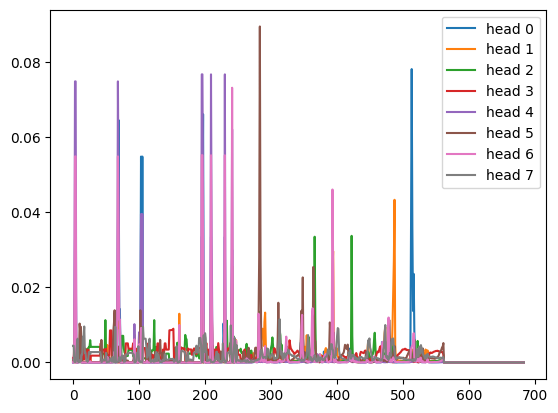

In [24]:
N = 49
B = 0
H = 3
L = 7
specific_head = False
plt.plot(attn_layers[L, B, :, L, :].T) if specific_head == False else plt.plot(attn_layers[L, B, H, N, :])
legend = [f'head {i}' for i in range(attn_layers.shape[2])] if specific_head == False else [f'layer {i}' for i in range(attn_layers.shape[0])]
plt.legend(legend, loc='upper right')
#plt.scatter(y=attn_layers[L, B, H, N, :1000].T, x=torch.arange(attn_layers.shape[-1])[:1000], s=3, c='r')
plt.show()
#plt.scatter(torch.arange(attn_layers.shape[-1]), attn_layers[L, B, H, N, :], s=2, c='r')

In [251]:
pos.shape

torch.Size([8, 287, 562])

In [25]:
pos[0, 0][562-288:]

tensor([0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 

In [26]:
pos[0,100][-200:]

tensor([0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503, 0.1503,
        0.1503, 0.1503, 0.1503, 0.1503, 

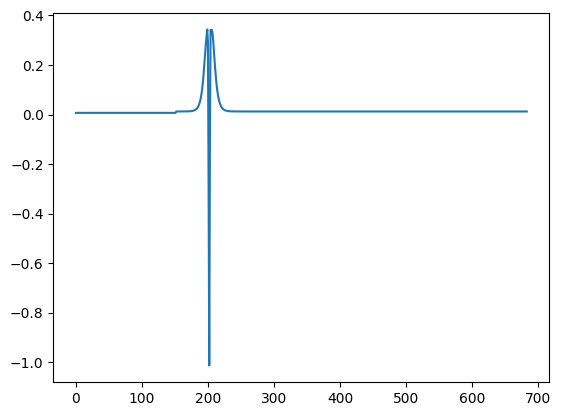

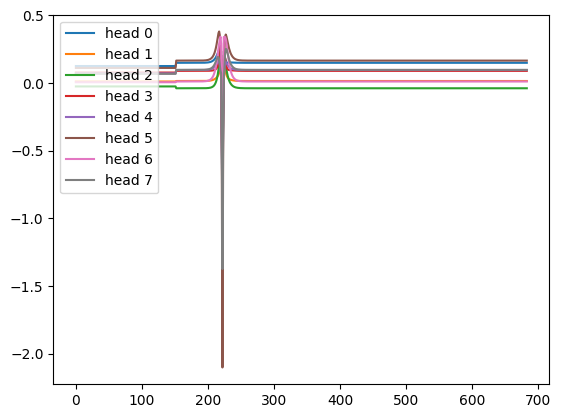

In [27]:
plt.plot(pos[6, 50, :])
plt.show()
plt.plot(pos[:, 70, :].T)
plt.legend([f'head {i}' for i in range(pos.shape[1])], loc='upper left')
plt.show()


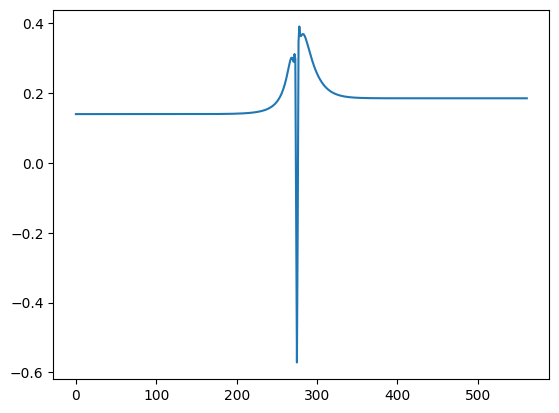

In [282]:
plt.plot(pos[7, 0, :])
plt.show()

In [120]:
import torch

In [121]:
a= torch.randn(10, 27, 256)
d0 = nn.Dropout(0.5)
a= d0(a.transpose(-1, -2)).transpose(-1, -2)

In [127]:
a[0,6]

tensor([ 0.0000,  5.0313,  0.0000, -0.0000, -0.0000,  0.1405,  0.0000, -0.8368,
         0.0000, -0.0000,  0.0000,  1.3433,  0.5267,  0.0000, -0.8593, -0.0000,
         0.0000, -0.0000, -2.2363,  1.5589,  0.0000, -1.1833,  0.0000, -0.0000,
        -0.0000, -0.0748, -0.0000, -1.9311, -3.0532, -0.0000,  0.0957, -0.0000,
        -0.0584, -0.0000, -0.0000,  0.0000, -3.7319,  0.0000, -1.7989,  1.2483,
        -1.6159, -0.6912,  0.0000,  0.2232, -4.0491, -0.0000, -0.0000, -0.0000,
        -1.8224,  0.1816, -0.0000,  0.0000,  0.7173,  0.7913, -0.0000, -0.0000,
         3.1974,  0.6956, -0.5368, -0.3469,  0.0000,  0.0000, -0.0000,  3.0759,
         0.0000, -3.3976, -0.0000, -0.0000,  1.0925, -2.1674, -0.0000, -0.0000,
         0.0000, -0.2690, -0.0000, -0.0000,  0.6925, -2.5726,  0.0000, -0.0000,
         0.0000, -0.0000, -1.1049, -0.0000,  0.0000, -0.0000, -0.0000, -0.0381,
        -0.9249, -1.3988, -0.7271, -0.0000,  0.0000, -0.7208, -0.0000, -0.0000,
         0.3819,  0.5982,  0.0000,  0.00

In [ ]:
def move_to_device(sub_batch, device):
    for k, v in sub_batch.items():
        if isinstance(v, torch.Tensor):
            sub_batch[k] = v.to(device)
    return sub_batch

In [ ]:
sb = create_subbatches(**z)

In [ ]:
sb[0].keys()

dict_keys(['audio', 'audio_lens', 'tokens', 'token_lens', 'prev_state_indices'])

In [ ]:
(1/15)

0.06666666666666667

In [ ]:
torch.nn.ReLU

In [ ]:
sb[3]['prev_state_indices']

tensor([ 1,  5,  6, 11])

In [ ]:
# init uniform
q = torch.FloatTensor(1, 12, 256).uniform_(-1, 1)
k = torch.FloatTensor(1, 12, 256).uniform_(-1, 1)
dots = torch.einsum('bnd,bmd->bnm', q, k) / q.shape[-1]**0.5
dots.softmax(dim=-1)[0][0]

tensor([0.0861, 0.0966, 0.0760, 0.0431, 0.0482, 0.0565, 0.1114, 0.1451, 0.0998,
        0.0939, 0.0719, 0.0715])

In [ ]:
z['metadata'][2]

[{'unique_id': 'f6a3719a-1aa1-48c0-9792-4a28ffd69cb8',
  'timings': {'segment_start': 437.65, 'segment_end': 441.61},
  'recording_id': 'GeverTulley_2007U',
  'utterance_id': 'GeverTulley_2007U-31',
  'speaker': 'GeverTulley_2007U'}]

In [ ]:
z.keys()

dict_keys(['audio', 'audio_lens', 'tokens', 'token_lens', 'segment_lens'])

In [ ]:
z['audio'].shape

torch.Size([6, 265920])

In [ ]:
import torch.nn as nn
from einops import rearrange
class DynamicPositionBiasXL(nn.Module):
    '''Adapted From Phil Wang's x-transformers library
       Altered to work with attention matrix that is not square
    '''
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            nn.ReLU()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                nn.ReLU()
            ))

        self.mlp.append(nn.Linear(dim, heads))
        self.history_decay = nn.Parameter(torch.ones(1))
      

    @staticmethod
    def fetch_module_kwargs(kwargs):
        return {
            'dim': kwargs.get('dpos_dim', 64),
            'depth': kwargs.get('dpos_depth', 2),
            'log_distance': kwargs.get('dpos_log_distance', False),
            'norm': kwargs.get('dpos_norm', False)
        }

    def forward(self, i, j, device, dtype):
        # get the (i x j) matrix of distances
        assert i >= 1 and j >= 1 and i <= j, 'I should be in the range [1, j] and j >= 1'
        
        seq_arange = torch.arange(i, device = device)
        context_arange = torch.arange(j, device = device)
        indices = rearrange(seq_arange, 'i -> i 1') - rearrange(context_arange, 'j -> 1 j')
        indices += (j-1)
        
        # input to continuous positions MLP
        pos = torch.arange(-i + 1, (j+i), device = device, dtype = dtype)
        pos = rearrange(pos, '... -> ... 1')
     
        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)
        
        for layer in self.mlp:
            pos = layer(pos)

        # get position biases        
        bias = pos[indices]
        bias = rearrange(bias, 'i j h -> h i j')

        if j > i:
            history_len = j - i
            bias[:, :, :history_len] *= self.history_decay

        return bias

In [ ]:
dpos = DynamicPositionBiasXL(dim=256, heads=8, depth=2)
pos = dpos(10, 10, 'cpu', torch.float32).squeeze()

In [ ]:
test_mask = (torch.randn(10) <0.5)

In [ ]:
(test_mask +1).bool()

tensor([True, True, True, True, True, True, True, True, True, True])

In [ ]:
r = torch.randn(10) *10

In [ ]:
r[r<5] = 10

In [ ]:
-1422.823974609375 == -1422.823974609375

True

: 

In [ ]:
AUDIOTOTAL: -1422.823974609375
WER (nemo): 0.2394909090909091

AUDIOTOTAL: -1422.823974609375
WER (nemo): 0.2394909090909091

AUDIOTOTAL: -1422.823974609375
WER (nemo): 0.23945454545454545


AUDIOTOTAL: -1422.8238525390625
WER (nemo): 0.2394909090909091

AUDIOTOTAL: -1422.8238525390625
WER (nemo): 0.2394909090909091




tensor([10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,  8.9258, 17.1805,
        10.0000, 10.0000])

In [ ]:
AUDIOTOTAL: -1422.82373046875
WER (nemo): 0.9292

AUDIOTOTAL: -1422.823974609375
WER (nemo): 0.9292363636363636


In [ ]:
0.7781906166848194
0.778211296926916
0.7781837232707871
0.7781492562006259

In [ ]:
0.7781630430286904
0.7781630430286904

In [ ]:
AUDIOTOTAL: -1422.823974609375
WER (nemo): 0.7783146981373995

AUDIOTOTAL: -1422.823974609375
WER (nemo): 0.7783146981373995
0.04769553168902431


0.08378181818181818
0.08367272727272727

In [ ]:
AUDIOS TOTAL: -1422.823974609375
WER (nemo): 0.09825454545454546

AUDIOS TOTAL: -1422.823974609375
WER (nemo): 0.0982909090909091

AUDIOS TOTAL: -1422.823974609375
WER (nemo): 0.0982909090909091


In [ ]:
import torch
from einops import rearrange

In [ ]:
dots_ein[0][0]

tensor([[-41.0888, -51.0194,  64.5614,  ..., -29.1492, 101.4100, -58.6910],
        [ -6.2383, -37.3124, 106.6235,  ..., -56.6056, -39.9867, -51.3461],
        [ -3.1641, -23.2686, -18.4355,  ..., -22.1669, -24.1924, -29.1323],
        ...,
        [-65.7582,  23.7784, -74.1952,  ...,  -0.4829,  22.9448,  83.3716],
        [  5.5886, -29.3647,  50.4721,  ...,  21.1906,  79.5414, -37.8894],
        [-20.1722,   7.4665, 116.8719,  ..., -60.9847,  -3.3432, -49.8833]])

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

In [ ]:
def einsum_attn():
    B,H,N,D = 10,8,230,32
    q = torch.randn(B, H, N, D).cuda()
    k = torch.randn(B, 1, N, D).cuda()
    
    dots_ein = torch.einsum('bhld,bhmd->bhlm', q, k) * 10

In [ ]:
def bad_attn():
    B,H,N,D = 10,8,230,32
    q = torch.randn(B, H, N, D).cuda()
    k = torch.randn(B, H, N, D).cuda()

    remap = lambda t: rearrange(t, 'b h n d -> (b h) n d')
    revert = lambda t: rearrange(t, '(b h) n d -> b h n d', b=B, h=H)
    q,k = map(remap, (q,k))
    dots_mm = torch.baddbmm(batch1=q, batch2=k.transpose(-2, -1), beta=0.0, alpha=10.0, input=torch.empty(10*8, 230, 230).cuda())
    dots_mm = revert(dots_mm)

In [ ]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        bad_attn()
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [80, 32] but got: [10, 32].

In [ ]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        einsum_attn()
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         1.88%     254.000us        99.73%      13.490ms      13.490ms       0.000us         0.00%     516.000us     516.000us             1  
                                               aten::to         3.05%     412.000us        24.15%       3.267ms       1.633ms       0.000us         0.00%     422.000us     211.000us             2  
         

In [2]:
import triton
import torch

In [ ]:
triton.tools.

In [3]:
B,H,N,D=3,8,230,32
q = torch.randn(B, H, N, D).cuda()
k = torch.randn(B, H, N, D).cuda()
sparsity_mask = q > 10000
q[sparsity_mask] = 0
print(sparsity_mask[...,-1].shape)
triton.ops.blocksparse.matmul(block=32, mode='dsd', device='cuda', layout=sparsity_mask[...,-1])(a=q, b=k)

torch.Size([3, 8, 230])


RuntimeError: Triton requires CUDA 11.4+

: 

In [10]:
triton.ops.blocksparse.matmul(block=32, mode='sdd', device='cuda', layout=)

AttributeError: 'str' object has no attribute 'shape'

In [3]:
import torch
from einops import rearrange
from vector_quantize_pytorch import VectorQuantize


In [284]:
kv = torch.randn(2, 12, 4, 1, 47, 32)
conv_pointwise = torch.nn.Conv1d(32, 32, 1)
act = torch.nn.SiLU()
KV, L, B, H, N, D = kv.shape
conv_depth = torch.nn.Conv1d(32, 32, 4, stride=2, groups=32, padding=1)
vq = VectorQuantize(
    dim = 32,
    codebook_size =
)

kv = rearrange(kv, 'kv l b h n d -> (kv l b h) d n')
kv = conv_pointwise(kv)
kv = act(kv)
kv = conv_depth(kv).transpose(-2, -1)
print(k.shape)

SyntaxError: invalid syntax (1046607132.py, line 9)

In [191]:
import torch.nn as nn

In [283]:
k, v = torch.randn(2, 12, 4, 1, 47, 32)
layer_pos_q = torch.randn(1, 12, 32)
L, B, H, N, D = k.shape
k = rearrange(k, 'l b h n d -> (b h n) l d')
v = rearrange(v, 'l b h n d -> (b h n) l d')
ffk, ffv = nn.Linear(D, D), nn.Linear(D, D)
kvf, vvf = ffk(k), ffv(v)
kv = torch.cat([k, v], dim=0)
kvnorm = kv / kv.norm(dim=-1, keepdim=True)
layer_pos_q_norm = layer_pos_q / layer_pos_q.norm(dim=-1, keepdim=True)
print(kvnorm.shape, layer_pos_q_norm.shape)
sim = torch.einsum('s l d, b p d -> b l p', layer_pos_q_norm, kvnorm)
attn = sim.softmax(dim=-1)
kv_out = attn.matmul(kv)
kv_out1 = rearrange(kv_out, '(kv b h n ) l d -> (kv b h l) n d', kv=2, b=B, h=H, n=N, d=D)
kv_out2 = rearrange(kv_out, '(kv b h n) l d -> kv l b h n d', kv=2, b=B, h=H, n=N, d=D)
print(kv_out1.shape, kv_out2.shape)

torch.Size([376, 12, 32]) torch.Size([1, 12, 32])
torch.Size([96, 47, 32]) torch.Size([2, 12, 4, 1, 47, 32])


In [298]:
x = torch.randn(10, 32, 470)
conv = torch.nn.Conv1d(32, 32, 8, stride=2, padding=0)
x = conv(x)
print(x.shape)
x = conv(x)
print(x.shape)
x = conv(x)
print(x.shape)
x = conv(x)
print(x.shape)
x = conv(x)
print(x.shape)
x = conv(x)

torch.Size([10, 32, 232])
torch.Size([10, 32, 113])
torch.Size([10, 32, 53])
torch.Size([10, 32, 23])
torch.Size([10, 32, 8])


In [228]:
kv_out1[2,:,0]

tensor([ 0.1728,  0.1750,  0.1582, -0.1261, -0.0012,  0.3190,  0.0314,  0.3462,
         0.0347,  0.0106, -0.3657,  0.1372, -0.1629,  0.0996, -0.0383,  0.4446,
         0.2881, -0.7578,  0.4497,  0.2040, -0.0979, -0.0760,  0.1567, -0.2148,
        -0.0933,  0.2138, -0.4290, -0.1448,  0.3515, -0.3785,  0.3439,  0.1293,
        -0.4232, -0.2096, -0.3043,  0.0161, -0.5005,  0.3965,  0.0175,  0.0440,
        -0.2726, -0.2690,  0.4237, -0.1046,  0.0741,  0.5477,  0.3078])

In [112]:
(attn[0][0].unsqueeze(-1) * v[0]).sum(dim=0)

tensor([ 0.1408, -0.4468, -0.0967, -0.1814, -0.1534, -0.1098, -0.2832, -0.0945,
        -0.1713, -0.6861,  0.0406,  0.2193, -0.2887,  0.1972, -0.0653,  0.1521,
        -0.0608, -0.1063,  0.3126,  0.7086, -0.3826, -0.1101,  0.1185, -0.0067,
        -0.0516, -0.1748,  0.8077, -0.3403, -0.4031,  0.1423,  0.5049,  0.2853])

In [86]:
out[0,0]

tensor([ 0.1408, -0.4468, -0.0967, -0.1814, -0.1534, -0.1098, -0.2832, -0.0945,
        -0.1713, -0.6861,  0.0406,  0.2193, -0.2887,  0.1972, -0.0653,  0.1521,
        -0.0608, -0.1063,  0.3126,  0.7086, -0.3826, -0.1101,  0.1185, -0.0067,
        -0.0516, -0.1748,  0.8077, -0.3403, -0.4031,  0.1423,  0.5049,  0.2853])

In [129]:
out.shape

torch.Size([188, 12, 32])

In [132]:

def get_cache_indices(x_lens, cache_lens, cache_kv, x):  # replace with a vmap
    # used later w/ gather to remove padding when cache is concatenated with current input
    max_new_len = (x_lens + cache_lens).max()

    B, H, N, D = x.shape[0], 1, (x.shape[1] + cache_kv.shape[-2]), cache_kv.shape[-1]

    indices = []
    for i in range(B):
        cache_indices = torch.arange(cache_lens[i], device='cpu')
        total_length = cache_lens[i] + x_lens[i]
        print(total_length)
        diff_from_max_len = max_new_len - total_length
        x_indices = torch.arange(x_lens[i]+diff_from_max_len, device='cpu') + cache_kv.shape[-2]
        if diff_from_max_len > 0:
            print('s')
            x_indices[-diff_from_max_len:] = N
        new_indices = torch.cat([cache_indices, x_indices])
        indices.append(new_indices)

    indices = torch.stack(indices, dim=0)
    
    indices = rearrange(indices, 'b n -> () () b () n ()').expand(2, 2,B,H,-1,D)
    return indices.to(x.device)

In [133]:
x = rearrange(torch.arange(20), 'n -> () n ()').repeat(2, 1, 1)
cache = rearrange(torch.arange(5), 'n -> () () n ()').repeat(2, 1, 1, 1)
x_lens = torch.tensor([11,11])
cache_lens = torch.tensor([3,4])
indices = get_cache_indices(x_lens, cache_lens, cache, x)[0][0]
x = x.unsqueeze(1)
zero_vector = torch.zeros_like(x[:,:,0,:]).unsqueeze(-1)

both = torch.cat([cache, x, zero_vector], dim=-2)
print(both.shape)
both.gather(dim=-2, index=indices)

tensor(14)
s
tensor(15)
torch.Size([2, 1, 26, 1])


tensor([[[[ 0],
          [ 1],
          [ 2],
          [ 0],
          [ 1],
          [ 2],
          [ 3],
          [ 4],
          [ 5],
          [ 6],
          [ 7],
          [ 8],
          [ 9],
          [10],
          [ 0]]],


        [[[ 0],
          [ 1],
          [ 2],
          [ 3],
          [ 0],
          [ 1],
          [ 2],
          [ 3],
          [ 4],
          [ 5],
          [ 6],
          [ 7],
          [ 8],
          [ 9],
          [10]]]])

In [134]:
indices.squeeze()

tensor([[ 0,  1,  2,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 25],
        [ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]])